In [51]:
%load_ext autoreload

In [52]:
%autoreload 2

In [53]:
from IPython.display import Image
from base64 import b64decode

import k3d
import randomcolor

In [54]:

def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='3d'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = np.max(distances)
            colors = k3d.helpers.map_colors(
                samples_distances, k3d.colormaps.basic_color_maps.WarmCool, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='3d'
        
        if None is not directions:
            directions_to_plot = np.hstack((samples, samples + directions))
            
            for i, dir_to_plot in enumerate(directions_to_plot):
                dir_to_plot = dir_to_plot.reshape((2, 3))
                if np.all(dir_to_plot[0] == dir_to_plot[1]):
                    continue
                color = int(colors[i]) if None is not colors else samples_color
                plt_line = k3d.line(dir_to_plot, 
                                    shader='mesh', width=directions_width, color=color)
                plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='3d'
        
        if None is not sharp_curves:
            rand_color = randomcolor.RandomColor()
            for i, vert_ind in sharp_curves.items():
                sharp_points_curve = mesh.vertices[vert_ind]
                if None is not sharpcurve_color:
                    color = sharpcurve_color
                else:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [55]:
import sys
sys.path.append('/home/artonson/repos/sharp_features/')

In [56]:

from sharpf.data.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.mesh_nbhoods import NBHOOD_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.data.point_samplers import SAMPLER_BY_TYPE, PoissonDiskSampler
from sharpf.utils.mesh_utils import trimesh_load

from copy import deepcopy
import json

import yaml
from yaml import Loader
import numpy as np
from tqdm import tqdm

In [ ]:
with open('/home/artonson/tmp/00000002/00000002_1ffb81a71e5b402e966b9341_trimesh_001.obj', 'rb') as f:
    mesh = trimesh_load(f)

In [ ]:
with open('/home/artonson/tmp/00000002/00000002_1ffb81a71e5b402e966b9341_features_001.yml') as f:
    features = yaml.load(f)

In [ ]:
with open('/home/artonson/repos/sharp_features/sharpf/data/dataset_config.json') as f:
    config = json.load(f)

In [82]:


def load_func_from_config(func_dict, config):
    return func_dict[config['type']].from_config(config)


def compute_curves_nbhood(features, vert_indices, face_indexes):
    """Extracts curves for the neighbourhood."""
    nbhood_sharp_curves = []
    for curve in features['curves']:
        nbhood_vert_indices = np.array([
            vert_index for vert_index in curve['vert_indices']
            if vert_index + 1 in vert_indices
        ])
        if len(nbhood_vert_indices) == 0:
            continue
        for index, reindex in zip(vert_indices, np.arange(len(vert_indices))):
            nbhood_vert_indices[np.where(nbhood_vert_indices == index - 1)] = reindex
        nbhood_curve = deepcopy(curve)
        nbhood_curve['vert_indices'] = nbhood_vert_indices
        nbhood_sharp_curves.append(nbhood_curve)

    nbhood_features = {'curves': nbhood_sharp_curves}
    return nbhood_features



In [83]:
config = {
  "n_patches_per_mesh": 1,
  "neighbourhood": {
    "type": "random_euclidean_sphere",
    "n_vertices": 500,
    "centroid": 0,
    "radius": 10.0,
    "radius_delta": 0.5
  },
  "sampling": {
    "type": "poisson_disk",
    "n_points": 4096,
    "upsampling_factor": 3,
    "poisson_disk_radius": 0.1
  },
  "noise": {
    "type": "no_noise",
  },
  "annotation": {
    "type": "resampling",
    "sharp_discretization": 0.1,
    "distance_upper_bound": 3.2
  }
}

In [84]:
n_patches_per_mesh = config['n_patches_per_mesh']
nbhood_extractor = load_func_from_config(NBHOOD_BY_TYPE, config['neighbourhood'])
sampler = load_func_from_config(SAMPLER_BY_TYPE, config['sampling'])
noiser = load_func_from_config(NOISE_BY_TYPE, config['noise'])
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, config['annotation'])


In [85]:
chunk = ABCChunk(['/home/artonson/tmp/abc/abc_0056_obj_v00.7z', '/home/artonson/tmp/abc/abc_0056_feat_v00.7z'])

In [86]:
item = chunk.get("00560651_308a573e0ac8c0365257e352_001")

In [87]:
mesh = trimesh_load(item.obj)
features = yaml.load(item.feat, Loader=Loader)

In [93]:
point_patches = []

# index the mesh using a neighbourhood functions class
# (this internally may call indexing, so for repeated invocation one passes the mesh)
nbhood_extractor.index(mesh)

for patch_idx in tqdm(range(n_patches_per_mesh)):
    # extract neighbourhood
    nbhood, orig_vert_indices, orig_face_indexes = nbhood_extractor.get_nbhood()

    # sample the neighbourhood to form a point patch
    points, normals = sampler.sample(nbhood)

    # create a noisy sample
    noisy_points = noiser.make_noise(points, normals)

    # create annotations: condition the features onto the nbhood, then compute the TSharpDF
    nbhood_features = compute_curves_nbhood(features, orig_vert_indices, orig_face_indexes)
    distances, directions = annotator.annotate(nbhood, nbhood_features, noisy_points)

    has_sharp = any(curve['sharp'] for curve in nbhood_features['curves'])
    patch_info = {
        'points': noisy_points,
        'distances': distances,
        'directions': directions,
        'item_id': 'item.item_id',
        'orig_vert_indices': orig_vert_indices,
        'orig_face_indexes': orig_face_indexes,
        'has_sharp': has_sharp
    }
    point_patches.append(patch_info)
    
display_sharpness(mesh=mesh, plot_meshvert=False,
                  samples=point_patches[0]['points'], samples_psize=0.4,
                  samples_distances=point_patches[0]['distances'])

  0%|          | 0/1 [00:00<?, ?it/s]/home/artonson/repos/sharp_features/sharpf/data/annotation.py:82: RuntimeWarning: invalid value encountered in true_divide
  directions[~far_from_sharp] /= np.linalg.norm(directions[~far_from_sharp], axis=1, keepdims=True)
100%|██████████| 1/1 [00:27<00:00, 27.12s/it]
/home/artonson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/artonson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [48]:
!pip install segmentation-models-pytorch

  Using cached https://files.pythonhosted.org/packages/20/c6/67e9d555d41094988aaaf033b1d7e732a326a2ef41a15b81211b56e464ce/segmentation_models_pytorch-0.0.3-py3-none-any.whl


In [50]:
!pwd

/home/artonson/repos/sharp_features/notebooks


In [21]:
import efficientnet_pytorch.utils
efficientnet_pytorch.utils.get

In [58]:
import h5py

In [59]:
with h5py.File('/home/artonson/tmp/abc/patches/abc_0020_4832_4983.hdf5', 'r') as f:
    print(f.keys())
    points = np.array(f['points'])
    distances = np.array(f['distances'])
    directions = np.array(f['directions'])

<KeysViewHDF5 ['directions', 'distances', 'has_sharp', 'item_id', 'normals', 'orig_face_indexes', 'orig_vert_indices', 'points']>


In [73]:
print(idx)

590


In [87]:
from scipy.stats import special_ortho_group
R = special_ortho_group.rvs(3)

idx = 590#np.random.randint(len(points))
curr_points = np.dot((points[idx] - np.mean(points[idx])), R)[:,:-1]
#points_2d = np.dot(np.array([[0, 0, 1], [0, 1, 0]]), curr_points.T)

In [88]:
print(min(curr_points[:,0]),max(curr_points[:,0]))
print(min(curr_points[:,1]),max(curr_points[:,1]))

-10.427840882421135 -7.014472478841603
0.7858933392621992 5.7338418881741005


In [89]:
x,y = np.meshgrid(np.linspace(min(curr_points[:,0]), max(curr_points[:,0]), 45), np.linspace(min(curr_points[:,1]), max(curr_points[:,1]), 45))#np.meshgrid(np.arange(curr_points.shape[0]), np.arange(curr_points.shape[0]))

x[0, 5], y[0, 5]
x[1, 5], y[1, 5]

(-10.039958109287097, 0.8983467153738333)

In [90]:
import matplotlib.pyplot as plt

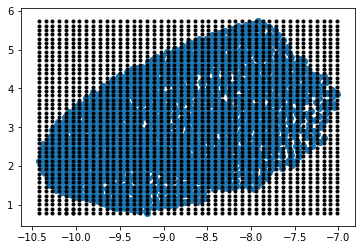

In [91]:
plt.plot(x[0, 5], y[0, 5], marker='.', color='k', linestyle='none')
plt.plot(x[1, 5], y[1, 5], marker='.', color='k', linestyle='none')
plt.plot(x[0, 4], y[0, 4], marker='.', color='k', linestyle='none')
plt.plot(x[1, 4], y[1, 4], marker='.', color='k', linestyle='none')
plt.plot(x, y, marker='.', color='k', linestyle='none')
plt.scatter(curr_points[:,0], curr_points[:,1])

In [81]:
polygons = []
polygon_inds = []
for i in range(len(x)-1):
    for j in range(len(x[i])-1):
        x1, y1, x2, y2 = x[i][j], y[i][j], x[i][j+1], y[i+1][j]
        tmp = []
        tmp_ind = []
        for ind, p in enumerate(curr_points):
            if (p[0] <= x2 and p[0] >= x1 and p[1] <= y2 and p[1] >= y1):
                tmp.append(p)
                tmp_ind.append(ind)
        polygons.append(tmp)
        polygon_inds.append(tmp_ind)


In [82]:
polygon_inds

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1777],
 [1585],
 [599],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1987],
 [877],
 [863],
 [1639],
 [769],
 [1999],
 [],
 [265],
 [],
 [906],
 [432],
 [],
 [1320],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1502],
 [479],
 [1631],
 [],
 [505],
 [944, 1899],
 [1564],
 [1334],
 [165, 243],
 [],
 [494, 819],
 [183],
 [1738],
 [],
 [1236],
 [1745],
 [652],
 [],
 [1996],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [390],
 [],
 [206, 288],
 [],
 [453, 1531],
 [199],
 [220],
 [1389, 1706],
 [78, 531],
 [492],
 [1870],
 [574],
 [1815, 1938],
 [633, 1348],
 [681],
 [237, 789],
 [],
 [653, 1207],
 [40, 122],
 [1884],
 [1

In [83]:
i = 0
j = 0
tmp = []
depth = []#np.zeros((20,20))
points_4040 = []
for el in polygon_inds:
    if len(el) > 0:
        ind_z = np.argmax(curr_points[:, -1][el])
        z = curr_points[:, -1][el[ind_z]]
        print(z)
        points_4040.append([curr_points[:, 0][el[ind_z]], curr_points[:, 1][el[ind_z]]])
    else:
        z = 0
        
    depth.append(z)
    
        

5.1516856209466395
5.063678787717336
5.137644478040889
5.233342685119113
5.185262126837474
5.248260881297277
5.224981571253768
5.169549847243026
5.236947532930583
5.233374591928231
5.2348754491213105
5.225921853881115
5.187448444140068
5.338334555881583
5.336571999171746
5.323819873620603
5.31737395581505
5.333290778198647
5.3453998869333015
5.278620944108719
5.339757402233185
5.330350181926007
5.338702643877752
5.325215626844795
5.319053791841799
5.310746832604192
5.3327147849248515
5.354211161167735
5.434483060017776
5.430898609479127
5.457889050953967
5.394473214600944
5.402707858678864
5.417121012819076
5.403347866528239
5.440218089579905
5.420126783679254
5.423134060968173
5.455492701313358
5.390394877327349
5.444096697508496
5.444138947252048
5.454691442291205
5.4309483384000625
5.455238101832391
5.40597805775236
5.433649125434851
5.444643510164465
5.5439214130890075
5.495692442886594
5.4974097635852806
5.5517841213409564
5.5454804586809425
5.541889777669146
5.506651380713405
5.5

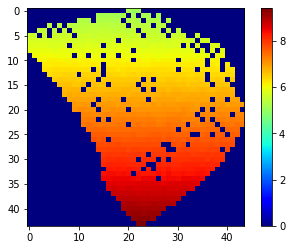

In [84]:
plt.imshow(np.array(depth).reshape((44, 44)), cmap='jet')
plt.colorbar()

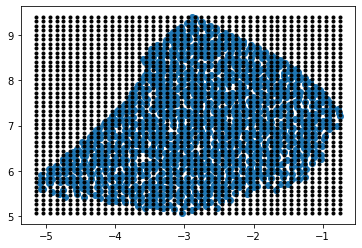

In [85]:
plt.scatter(np.array(points_4040)[:, 0], np.array(points_4040)[:, 1])
plt.plot(x, y, marker='.', color='k', linestyle='none')


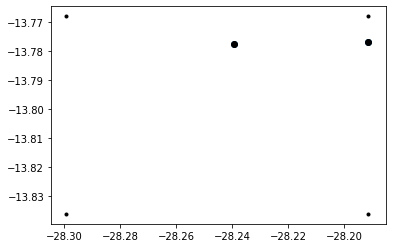

In [257]:
plt.plot(x[-2, -2], y[-2, -1], marker='.', color='k', linestyle='none')
plt.plot(x[-2, -1], y[-2, -1], marker='.', color='k', linestyle='none')
plt.plot(x[-1, -2], y[-1, -2], marker='.', color='k', linestyle='none')
plt.plot(x[-1, -1], y[-1, -1], marker='.', color='k', linestyle='none')
plt.scatter(np.array(tmp)[:,0], np.array(tmp)[:,1])

plt.scatter(np.array(polygons[-1])[:,0], np.array(polygons[-1])[:,1], color='k')


In [74]:
from itertools import product
c = list(product(grid[0], grid[-1]))

In [75]:
c

[(array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([0, 0, 0, ..., 0, 0, 0])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([1, 1, 1, ..., 1, 1, 1])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([2, 2, 2, ..., 2, 2, 2])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([3, 3, 3, ..., 3, 3, 3])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([4, 4, 4, ..., 4, 4, 4])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([5, 5, 5, ..., 5, 5, 5])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([6, 6, 6, ..., 6, 6, 6])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([7, 7, 7, ..., 7, 7, 7])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([8, 8, 8, ..., 8, 8, 8])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([9, 9, 9, ..., 9, 9, 9])),
 (array([   0,    1,    2, ..., 2045, 2046, 2047]),
  array([10, 10, 10, ..., 10, 10, 10])),
 (array([   0,    1,    2, ..., 2045,

In [ ]:
def make_stupid_projection(points, R):
    xv, yv = np.meshgrid(points.shape)
    for x in xv:
        for y in yv:
            
    return
ds = []
target = 
for i in range(len(points)):
    R = special_ortho_group.rvs(3)
    curr_points = np.dot((points[idx] - np.mean(points[idx])), R)
    ds.append(curr_points)
    R = special_ortho_group.rvs(3)
    curr_points = np.dot((points[idx] - np.mean(points[idx])), R)
    ds.append(curr_points)
    

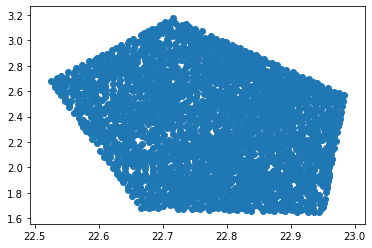

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(curr_points[:,0], curr_points[:,1])

In [86]:

# d = np.array(distances[idx])
# d[d>1.0] = 1.0
display_sharpness(mesh=None, plot_meshvert=False,
                  samples=points[idx], samples_psize=0.2,
                  samples_distances=distances[idx])

/home/artonson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()